In [1]:
import GAN.models as models
import GAN.cms_datasets as cms
import GAN.plotting as plotting
import GAN.preprocessing as preprocessing
import GAN.base as base

Using TensorFlow backend.


In [2]:
import GAN.utils as utils

reload(utils)

class Parameters(utils.Parameters):
    
    load_datasets=utils.param(["moriond_v9","abs(ScEta) < 1.5"])

#     c_names = utils.param(['Pt','ScEta','Phi','rho'])
#     x_names = utils.param(['R9','SigmaIeIe','S4','EtaWidth','PhiWidth','CovarianceIetaIphi',
#                'CovarianceIphiIphi', ])
    c_names = utils.param(['Phi'])## ,'ScEta'])
    x_names = utils.param(['EtaWidth'])
    
    feat_transform = utils.param('gaus')
    
    g_opts=utils.param(dict(name="G_256x5",kernel_sizes=[256]*5,do_bn=False))
    pretrain_g = utils.param(False)
    d_opts=utils.param(dict(name="D_256x5",kernel_sizes=[256]*5,#,do_bn=True,
                        clip_weights=1.e-2,activation=None)) # weights clipping and no actication
    #dm_opts=utils.param(dict(optimizer="RMSprop",opt_kwargs=dict(lr=0.00002, decay=6e-6)))
    #am_opts=utils.param(dict(optimizer="RMSprop",opt_kwargs=dict(lr=0.00002, decay=6e-6)))
    dm_opts=utils.param(dict(optimizer="RMSprop",opt_kwargs=dict(lr=0.00001)))#, decay=6e-6)))
    am_opts=utils.param(dict(optimizer="RMSprop",opt_kwargs=dict(lr=0.00001)))#, decay=6e-6)))
    
    
    epochs=utils.param(100)
    batch_size=utils.param(4096)
    plot_every=utils.param(10)
    
    frac_data=utils.param(10)
    
    loss = "wgan_loss" # use WGAN loss 
    gan_targets = 'gan_targets_hinge' # hinge targets are 1, -1 instead of 0, 1
    schedule = [0]*5+[1]*2 # number of critic iterations per generator iterations
    
class MyApp(utils.MyApp):
    classes = utils.List([Parameters])

notebook_parameters = Parameters(MyApp()).get_params()

globals().update(notebook_parameters)
DM_OPTS.update( {"loss":LOSS} )
AM_OPTS.update( {"loss":LOSS} )
notebook_parameters


{'AM_OPTS': {'loss': 'wgan_loss',
  'opt_kwargs': {'lr': 1e-05},
  'optimizer': 'RMSprop'},
 'BATCH_SIZE': 4096,
 'C_NAMES': ['Phi'],
 'DM_OPTS': {'loss': 'wgan_loss',
  'opt_kwargs': {'lr': 1e-05},
  'optimizer': 'RMSprop'},
 'D_OPTS': {'activation': None,
  'clip_weights': 0.01,
  'kernel_sizes': [256, 256, 256, 256, 256],
  'name': 'D_256x5'},
 'EPOCHS': 100,
 'FEAT_TRANSFORM': 'gaus',
 'FRAC_DATA': 10,
 'GAN_TARGETS': 'gan_targets_hinge',
 'G_OPTS': {'do_bn': False,
  'kernel_sizes': [256, 256, 256, 256, 256],
  'name': 'G_256x5'},
 'LOAD_DATASETS': ['moriond_v9', 'abs(ScEta) < 1.5'],
 'LOSS': 'wgan_loss',
 'PLOT_EVERY': 10,
 'PRETRAIN_G': False,
 'SCHEDULE': [0, 0, 0, 0, 0, 1, 1],
 'X_NAMES': ['EtaWidth']}

In [3]:
reload(cms)

data,mc = cms.load_zee(*LOAD_DATASETS)


In [4]:
data.columns

Index(['index', 'run', 'rho', 'nvtx', 'mass', 'weight', 'SigMoM', 'Pt',
       'ScEta', 'Phi', 'R9', 'S4', 'SigmaIeIe', 'EtaWidth', 'PhiWidth',
       'CovarianceIphiIphi', 'SigmaRR', 'ScEnergy', 'CovarianceIetaIphi',
       'PhoIso03', 'ChIso03', 'ChIso03worst', 'ScPreshowerEnergy', 'PhoIDMVA',
       'SigEOverE', 'run_quantile'],
      dtype='object')

In [5]:
mc.columns

Index(['index', 'run', 'rho', 'nvtx', 'mass', 'weight', 'SigMoM', 'Pt',
       'ScEta', 'Phi', 'R9', 'S4', 'SigmaIeIe', 'EtaWidth', 'PhiWidth',
       'CovarianceIphiIphi', 'SigmaRR', 'ScEnergy', 'CovarianceIetaIphi',
       'PhoIso03', 'ChIso03', 'ChIso03worst', 'ScPreshowerEnergy', 'PhoIDMVA',
       'SigEOverE'],
      dtype='object')

In [6]:
c_names = C_NAMES
x_names = X_NAMES

data_c = data[c_names]
data_x = data[x_names]

mc_c = mc[c_names]
mc_x = mc[x_names]


In [7]:
data_x.columns, data_x.shape, data_c.columns, data_c.shape

(Index(['EtaWidth'], dtype='object'),
 (17520217, 1),
 Index(['Phi'], dtype='object'),
 (17520217, 1))

In [8]:
data_x.columns, data_c.columns

(Index(['EtaWidth'], dtype='object'), Index(['Phi'], dtype='object'))

In [9]:
mc_x.columns, mc_c.columns

(Index(['EtaWidth'], dtype='object'), Index(['Phi'], dtype='object'))

In [10]:
reload(models)

xz_shape = (1,len(x_names))
c_shape = (1,len(c_names))
gan = models.MyFFGAN( xz_shape, xz_shape, c_shape=c_shape,
                     g_opts=G_OPTS,
                     d_opts=D_OPTS,
                     dm_opts=DM_OPTS,
                     am_opts=AM_OPTS,
                     gan_targets=GAN_TARGETS
                    )

In [11]:
gan.get_generator()

(1, 1)


In [12]:
gan.get_discriminator()

In [13]:
gan.adversarial_compile(loss=LOSS,schedule=SCHEDULE)

In [14]:
gan.get_generator().summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
G_256x5_c_input (InputLayer)     (None, 1, 1)          0                                            
____________________________________________________________________________________________________
G_256x5_input (InputLayer)       (None, 1, 1)          0                                            
____________________________________________________________________________________________________
G_256x5_all_inputs (Concatenate) (None, 1, 2)          0           G_256x5_c_input[0][0]            
                                                                   G_256x5_input[0][0]              
____________________________________________________________________________________________________
G_256x5_up1_dense (Dense)        (None, 1, 256)        768         G_256x5_all_inputs[0][0]

In [15]:
gan.get_discriminator().summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
D_256x5_c_input (InputLayer)     (None, 1, 1)          0                                            
____________________________________________________________________________________________________
D_256x5_input (InputLayer)       (None, 1, 1)          0                                            
____________________________________________________________________________________________________
D_256x5_all_inputs (Concatenate) (None, 1, 2)          0           D_256x5_c_input[0][0]            
                                                                   D_256x5_input[0][0]              
____________________________________________________________________________________________________
D_256x5_down1_dense (Dense)      (None, 1, 256)        768         D_256x5_all_inputs[0][0]

In [16]:
gan.am.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
G_256x5_c_input (InputLayer)     (None, 1, 1)          0                                            
____________________________________________________________________________________________________
G_256x5_input (InputLayer)       (None, 1, 1)          0                                            
____________________________________________________________________________________________________
G_256x5_all_inputs (Concatenate) (None, 1, 2)          0           G_256x5_c_input[0][0]            
                                                                   G_256x5_input[0][0]              
____________________________________________________________________________________________________
G_256x5_up1_dense (Dense)        (None, 1, 256)        768         G_256x5_all_inputs[0][0]

In [17]:
gan.dm.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
D_256x5_c_input (InputLayer)     (None, 1, 1)          0                                            
____________________________________________________________________________________________________
D_256x5_input (InputLayer)       (None, 1, 1)          0                                            
____________________________________________________________________________________________________
D_256x5_all_inputs (Concatenate) (None, 1, 2)          0           D_256x5_c_input[0][0]            
                                                                   D_256x5_input[0][0]              
____________________________________________________________________________________________________
D_256x5_down1_dense (Dense)      (None, 1, 256)        768         D_256x5_all_inputs[0][0]

In [18]:
gan.gan.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
G_256x5_c_input (InputLayer)     (None, 1, 1)          0                                            
____________________________________________________________________________________________________
G_256x5_input (InputLayer)       (None, 1, 1)          0                                            
____________________________________________________________________________________________________
G_256x5_all_inputs (Concatenate) (None, 1, 2)          0           G_256x5_c_input[0][0]            
                                                                   G_256x5_input[0][0]              
____________________________________________________________________________________________________
D_256x5_c_input (InputLayer)     (None, 1, 1)          0                                   

In [19]:
gan.gan.outputs, gan.gan.inputs

([<tf.Tensor 'model_2/D_256x5_output/BiasAdd:0' shape=(?, 1) dtype=float32>,
  <tf.Tensor 'D_256x5_output/BiasAdd:0' shape=(?, 1) dtype=float32>],
 [<tf.Tensor 'G_256x5_c_input:0' shape=(?, 1, 1) dtype=float32>,
  <tf.Tensor 'G_256x5_input:0' shape=(?, 1, 1) dtype=float32>,
  <tf.Tensor 'D_256x5_c_input:0' shape=(?, 1, 1) dtype=float32>,
  <tf.Tensor 'D_256x5_input:0' shape=(?, 1, 1) dtype=float32>])

In [20]:
# plotting.plot_hists(data_x.values[:,0],mc_x.values[:,0],bins=100,range=[0,1.2])
# plt.show()
# plotting.plot_hists(data_x.values[:,1],mc_x.values[:,1],bins=100,range=[0,5e-2])

In [21]:
reload(preprocessing)

data_x,data_c,mc_x,mc_c,scaler_x,scaler_c = preprocessing.transform(data_x,data_c,mc_x,mc_c,FEAT_TRANSFORM)


In [22]:
data_x.shape,mc_x.shape

((17520217, 1, 1), (9616192, 1, 1))

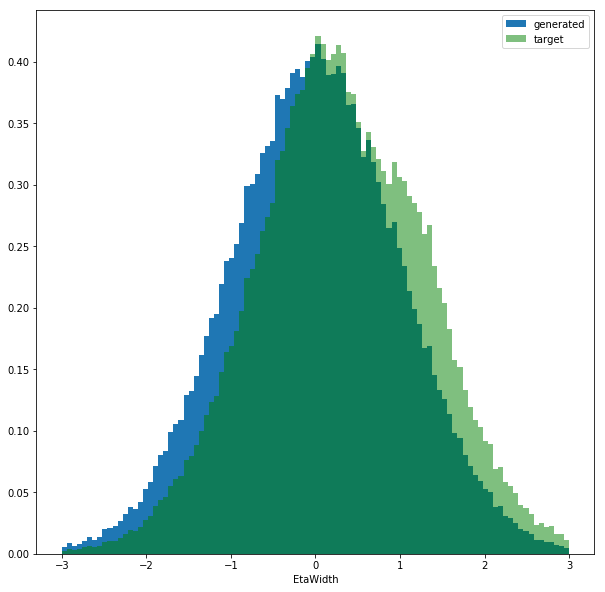

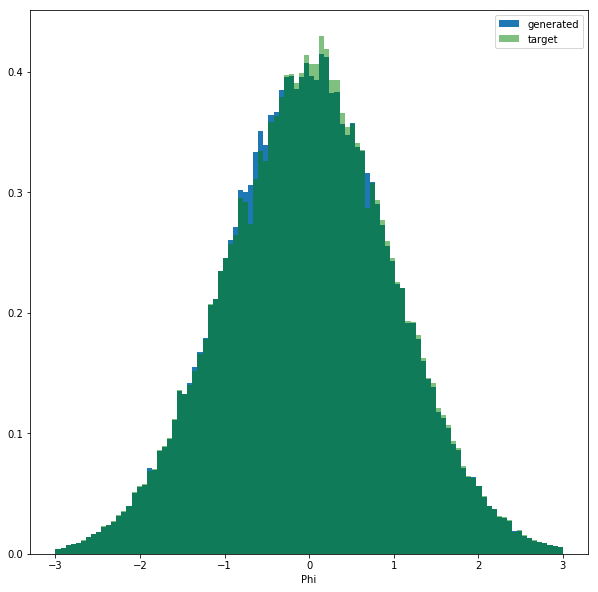

In [23]:
for ix in range(len(x_names)):
    plotting.plot_hists(data_x[:,0,ix],mc_x[:,0,ix],bins=100,range=[-3,3])
    plt.xlabel(x_names[ix])
    plt.show()

for ic in range(len(c_names)):
    plotting.plot_hists(data_c[:,0,ic],mc_c[:,0,ic],bins=100,range=[-3,3])
    plt.xlabel(c_names[ic])
    plt.show()


In [24]:
nmax = min(data_x.shape[0]//FRAC_DATA,mc_x.shape[0])

data_x_train,data_x_test,data_c_train,data_c_test = cms.train_test_split(data_x[:nmax],data_c[:nmax])
mc_x_train,mc_x_test,mc_c_train,mc_c_test = cms.train_test_split(mc_x[:nmax],mc_c[:nmax])

In [25]:
print(nmax)

1752021


In [ ]:
from keras.optimizers import RMSprop

if PRETRAIN_G:
    generator = gan.get_generator()
    generator.compile(loss="mse",optimizer=RMSprop(lr=1.e-3))
    generator.fit( [mc_c_train,mc_x_train], [mc_c_train,mc_x_train], epochs=1, batch_size=BATCH_SIZE  )

/users/musella/jupyter/GAN/GAN/base.py:132: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  callbacks = [plotter], **kwargs


Epoch 1/101
1306624/1314015 [============================>.] - ETA: 0s - loss: 0.0000e+00 - generator_loss: 0.0014 - generator_model_2_loss: -0.0442 - generator_D_256x5_output_loss: 0.0457 - discriminator_loss: -0.0014 - discriminator_model_2_loss: 0.0442 - discriminator_D_256x5_output_loss: -0.0457

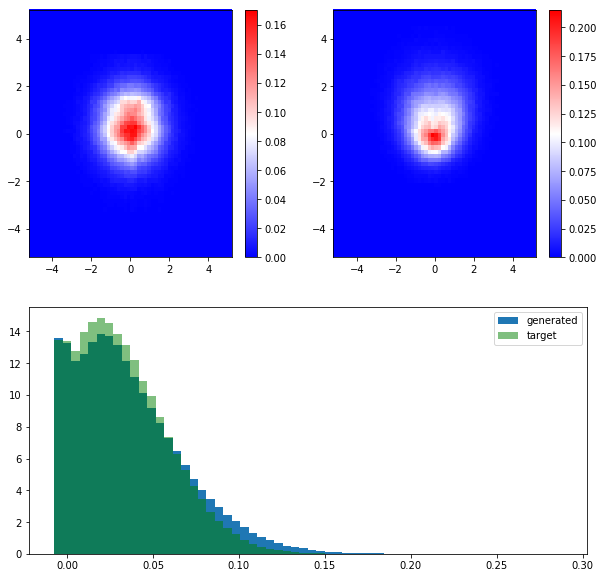

1314015/1314015 [==============================] - 94s - loss: 0.0000e+00 - generator_loss: 0.0014 - generator_model_2_loss: -0.0442 - generator_D_256x5_output_loss: 0.0456 - discriminator_loss: -0.0014 - discriminator_model_2_loss: 0.0442 - discriminator_D_256x5_output_loss: -0.0456    
Epoch 2/101
1314015/1314015 [==============================] - 19s - loss: 0.0000e+00 - generator_loss: 7.0362e-04 - generator_model_2_loss: -0.0126 - generator_D_256x5_output_loss: 0.0133 - discriminator_loss: -7.0362e-04 - discriminator_model_2_loss: 0.0126 - discriminator_D_256x5_output_loss: -0.0133     ETA: 0s - loss: 0.0000e+00 - generator_loss: 6.8724e-04 - generator_model_2_loss: -0.0125 - generator_D_256x5_output_loss: 0.0132 - discriminator_loss: -6.8724e-04 - discriminator_model_2_loss: 0.0125 - discriminator_D_256x5_output_l
Epoch 3/101
1314015/1314015 [==============================] - 18s - loss: 0.0000e+00 - generator_loss: 6.2646e-04 - generator_model_2_loss: -0.0190 - generator_D_256x5

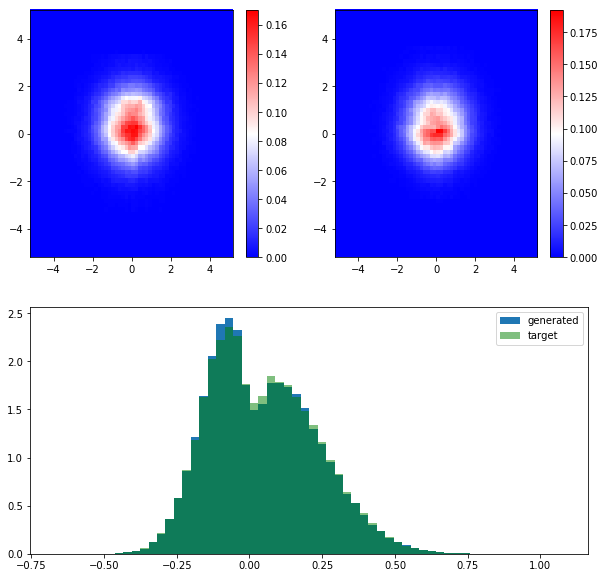

1314015/1314015 [==============================] - 91s - loss: 0.0000e+00 - generator_loss: 0.0017 - generator_model_2_loss: -0.0421 - generator_D_256x5_output_loss: 0.0438 - discriminator_loss: -0.0017 - discriminator_model_2_loss: 0.0421 - discriminator_D_256x5_output_loss: -0.0438    
Epoch 12/101
1314015/1314015 [==============================] - 19s - loss: 0.0000e+00 - generator_loss: 0.0017 - generator_model_2_loss: -0.0480 - generator_D_256x5_output_loss: 0.0497 - discriminator_loss: -0.0017 - discriminator_model_2_loss: 0.0480 - discriminator_D_256x5_output_loss: -0.0497    
Epoch 13/101
1314015/1314015 [==============================] - 18s - loss: 0.0000e+00 - generator_loss: 0.0017 - generator_model_2_loss: -0.0563 - generator_D_256x5_output_loss: 0.0580 - discriminator_loss: -0.0017 - discriminator_model_2_loss: 0.0563 - discriminator_D_256x5_output_loss: -0.0580    
Epoch 14/101
1314015/1314015 [==============================] - 18s - loss: 0.0000e+00 - generator_loss: 0.

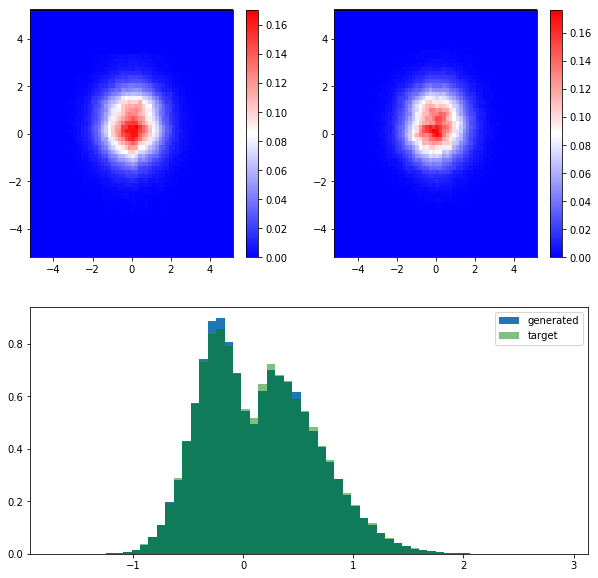

1314015/1314015 [==============================] - 93s - loss: 0.0000e+00 - generator_loss: 0.0042 - generator_model_2_loss: -0.1372 - generator_D_256x5_output_loss: 0.1414 - discriminator_loss: -0.0042 - discriminator_model_2_loss: 0.1372 - discriminator_D_256x5_output_loss: -0.1414    
Epoch 22/101
1314015/1314015 [==============================] - 19s - loss: 0.0000e+00 - generator_loss: 0.0046 - generator_model_2_loss: -0.1458 - generator_D_256x5_output_loss: 0.1504 - discriminator_loss: -0.0046 - discriminator_model_2_loss: 0.1458 - discriminator_D_256x5_output_loss: -0.1504    
Epoch 23/101
1314015/1314015 [==============================] - 19s - loss: 0.0000e+00 - generator_loss: 0.0050 - generator_model_2_loss: -0.1557 - generator_D_256x5_output_loss: 0.1608 - discriminator_loss: -0.0050 - discriminator_model_2_loss: 0.1557 - discriminator_D_256x5_output_loss: -0.1608    
Epoch 24/101
1314015/1314015 [==============================] - 19s - loss: 0.0000e+00 - generator_loss: 0.

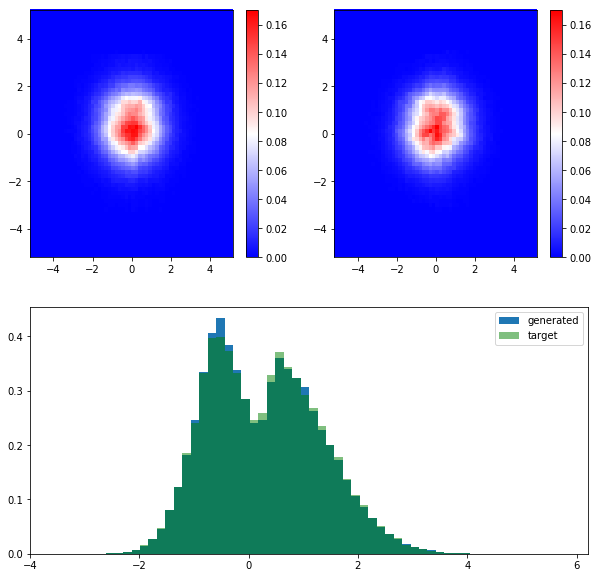

1314015/1314015 [==============================] - 98s - loss: 0.0000e+00 - generator_loss: 0.0088 - generator_model_2_loss: -0.2803 - generator_D_256x5_output_loss: 0.2891 - discriminator_loss: -0.0088 - discriminator_model_2_loss: 0.2803 - discriminator_D_256x5_output_loss: -0.2891    
Epoch 32/101
1314015/1314015 [==============================] - 19s - loss: 0.0000e+00 - generator_loss: 0.0097 - generator_model_2_loss: -0.3079 - generator_D_256x5_output_loss: 0.3176 - discriminator_loss: -0.0097 - discriminator_model_2_loss: 0.3079 - discriminator_D_256x5_output_loss: -0.3176    
Epoch 33/101
1314015/1314015 [==============================] - 19s - loss: 0.0000e+00 - generator_loss: 0.0106 - generator_model_2_loss: -0.3367 - generator_D_256x5_output_loss: 0.3473 - discriminator_loss: -0.0106 - discriminator_model_2_loss: 0.3367 - discriminator_D_256x5_output_loss: -0.3473    
Epoch 34/101
1314015/1314015 [==============================] - 18s - loss: 0.0000e+00 - generator_loss: 0.

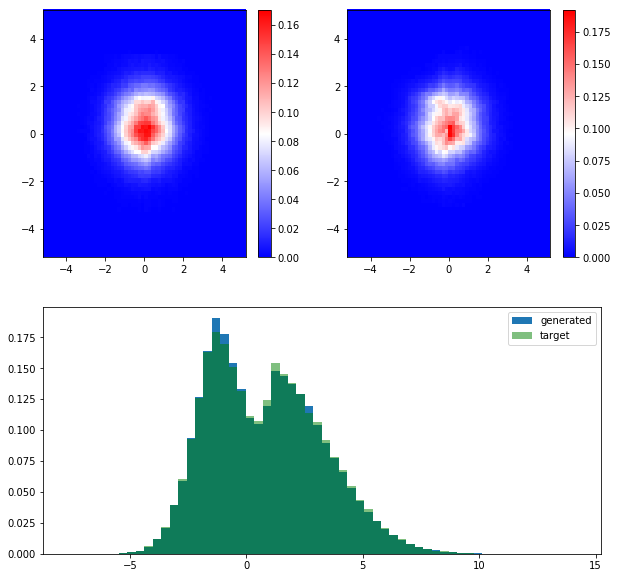

1314015/1314015 [==============================] - 99s - loss: 0.0000e+00 - generator_loss: 0.0209 - generator_model_2_loss: -0.7620 - generator_D_256x5_output_loss: 0.7829 - discriminator_loss: -0.0209 - discriminator_model_2_loss: 0.7620 - discriminator_D_256x5_output_loss: -0.7829    
Epoch 42/101
1314015/1314015 [==============================] - 18s - loss: 0.0000e+00 - generator_loss: 0.0224 - generator_model_2_loss: -0.8309 - generator_D_256x5_output_loss: 0.8533 - discriminator_loss: -0.0224 - discriminator_model_2_loss: 0.8309 - discriminator_D_256x5_output_loss: -0.8533    
Epoch 43/101
1314015/1314015 [==============================] - 19s - loss: 0.0000e+00 - generator_loss: 0.0238 - generator_model_2_loss: -0.8787 - generator_D_256x5_output_loss: 0.9026 - discriminator_loss: -0.0238 - discriminator_model_2_loss: 0.8787 - discriminator_D_256x5_output_loss: -0.9026    
Epoch 44/101
1314015/1314015 [==============================] - 19s - loss: 0.0000e+00 - generator_loss: 0.

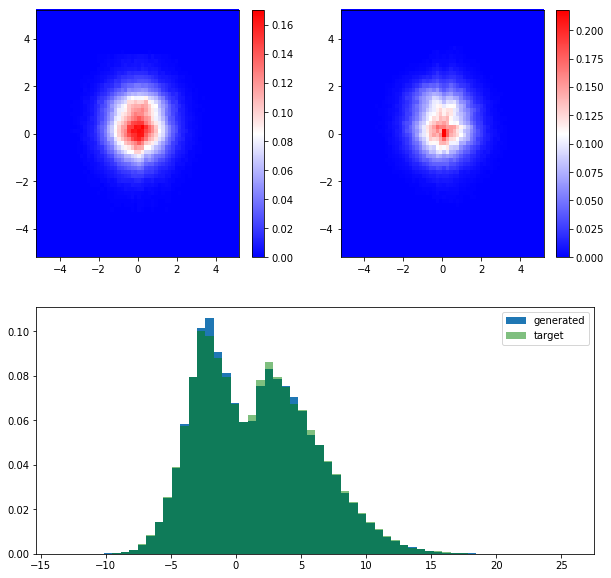

1314015/1314015 [==============================] - 88s - loss: 0.0000e+00 - generator_loss: 0.0387 - generator_model_2_loss: -1.4942 - generator_D_256x5_output_loss: 1.5329 - discriminator_loss: -0.0387 - discriminator_model_2_loss: 1.4942 - discriminator_D_256x5_output_loss: -1.5329    
Epoch 52/101
1314015/1314015 [==============================] - 18s - loss: 0.0000e+00 - generator_loss: 0.0413 - generator_model_2_loss: -1.5946 - generator_D_256x5_output_loss: 1.6360 - discriminator_loss: -0.0413 - discriminator_model_2_loss: 1.5946 - discriminator_D_256x5_output_loss: -1.6360    
Epoch 53/101
1314015/1314015 [==============================] - 19s - loss: 0.0000e+00 - generator_loss: 0.0439 - generator_model_2_loss: -1.6769 - generator_D_256x5_output_loss: 1.7208 - discriminator_loss: -0.0439 - discriminator_model_2_loss: 1.6769 - discriminator_D_256x5_output_loss: -1.7208    
Epoch 54/101
1314015/1314015 [==============================] - 18s - loss: 0.0000e+00 - generator_loss: 0.

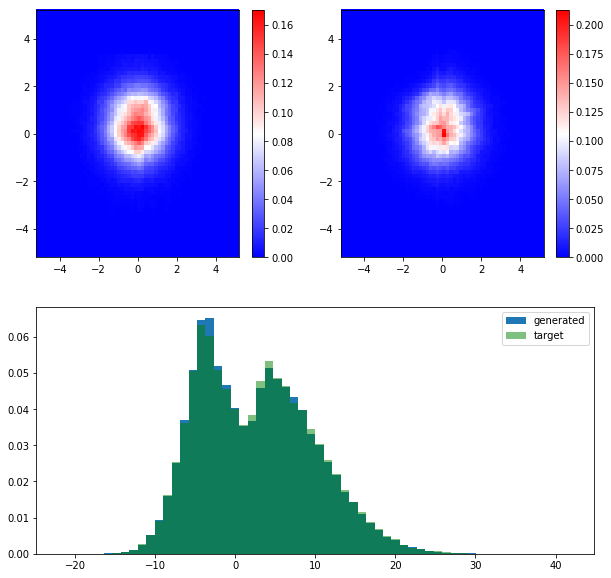

1314015/1314015 [==============================] - 90s - loss: 0.0000e+00 - generator_loss: 0.0644 - generator_model_2_loss: -2.5265 - generator_D_256x5_output_loss: 2.5910 - discriminator_loss: -0.0644 - discriminator_model_2_loss: 2.5265 - discriminator_D_256x5_output_loss: -2.5910    
Epoch 62/101
1314015/1314015 [==============================] - 18s - loss: 0.0000e+00 - generator_loss: 0.0672 - generator_model_2_loss: -2.6629 - generator_D_256x5_output_loss: 2.7302 - discriminator_loss: -0.0672 - discriminator_model_2_loss: 2.6629 - discriminator_D_256x5_output_loss: -2.7302    
Epoch 63/101
1314015/1314015 [==============================] - 18s - loss: 0.0000e+00 - generator_loss: 0.0717 - generator_model_2_loss: -2.8348 - generator_D_256x5_output_loss: 2.9065 - discriminator_loss: -0.0717 - discriminator_model_2_loss: 2.8348 - discriminator_D_256x5_output_loss: -2.9065    
Epoch 64/101
1314015/1314015 [==============================] - 18s - loss: 0.0000e+00 - generator_loss: 0.

In [ ]:
reload(base)

initial_epoch = 0
if hasattr(gan.model,"history"):
    initial_epoch = gan.model.history.epoch[-1]

do = dict(
    x_train=data_x_train,
    z_train=mc_x_train,
    c_x_train=data_c_train,
    c_z_train=mc_c_train,
          
    x_test=data_x_test,
    z_test=mc_x_test,
    c_x_test=data_c_test,
    c_z_test=mc_c_test,
    
    n_epochs=EPOCHS + initial_epoch +1,
    initial_epoch=initial_epoch,
    batch_size=BATCH_SIZE,
    plot_every=PLOT_EVERY,
)

base.MyGAN.adversarial_fit(gan,**do)


In [ ]:
mc_x_morphed = gan.get_generator().predict([mc_c_test,mc_x_test])[1]

data_p = gan.get_discriminator().predict([data_c_test,data_x_test])
mc_p   = gan.get_discriminator().predict([mc_c_test,mc_x_morphed])

In [ ]:
reload(plotting)

data_quantiles = np.percentile(data_c_test,[0,5,20,40,60,80,95,100])

# plotting.plot_summary_cond(data_x_test,data_c_test,mc_x_test,mc_c_test,mc_x_test,data_p,mc_p)
# plotting.plot_summary_cond(data_x_test,data_c_test,mc_x_morphed,mc_c_test,mc_x_test,data_p,mc_p)
plotting.plot_summary_cond(data_x_test,data_c_test,mc_x_morphed,mc_c_test,mc_x_test,data_p,mc_p,
                           do_slices=True,c_bounds=data_quantiles,saveas='wgan_test4.png')


In [ ]:
# plt.savefig('wgan_test1.png')